In [1]:
import time
import os

import scanpy
import numpy as np
import scipy.sparse as sp

import torch
from torch import optim
from torch.utils.data import DataLoader

import models.loadImg as loadImg
import models.modelsCNN as modelsCNN
import models.optimizer as optimizer

import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import gc
from skimage import io
import scipy.stats
from sklearn.metrics import pairwise_distances

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"] = '3'
use_cuda=True
datadir='/media/xinyi/data'
name='exp0'
plotsavepath='/media/xinyi/plots/cnnvae'+name
sampledir=plotsavepath
clustersavedir_alltrain=os.path.join(sampledir,'cluster_alltrain_reordered')
ep=311
with open(os.path.join(datadir,'processed','train_cnnvae_names'), 'rb') as input:
    allImgNames=pickle.load(input)
#plot by disease progression
br1003aSpecs=pd.read_excel('/media/xinyi/data/BR1003a specs.xlsx',header=10)
br301Specs=pd.read_excel('/media/xinyi/data/BR301 specs.xlsx',header=10)
br8018aSpecs=pd.read_excel('/media/xinyi/data/BR8018a specs.xlsx',header=10)
br1003aSpecs.index=br1003aSpecs.loc[:,'Position']
br301Specs.index=br301Specs.loc[:,'Position']
br8018aSpecs.index=br8018aSpecs.loc[:,'Position']

progList=np.copy(allImgNames)
for s in np.unique(allImgNames):
    ssplit=s.split('_')
    if 'br1003a'==ssplit[0]:
        prog_s=br1003aSpecs.loc[(ssplit[-1],'Pathology diagnosis')]
    elif 'br301'==ssplit[0]:
        prog_s=br301Specs.loc[(ssplit[-1],'Pathology diagnosis')]
    elif 'br8018a'==ssplit[0]:
        prog_s=br8018aSpecs.loc[(ssplit[-1],'Pathology diagnosis')]
    progList[allImgNames==s]=prog_s
    




In [3]:
metadata=pd.read_csv(os.path.join(datadir,'Supplementary Table 1_v1.csv'),header=0)
metadata.index=metadata.sample_id

In [4]:
allPatientIDs=np.repeat('none',allImgNames.size).astype(object)
for s in np.unique(allImgNames):
    sidx=allImgNames==s
    slideID=s.split('_')[0]
    coreID=s.split('_')[-1]
    allPatientIDs[sidx]=metadata.patient_id[slideID+'_'+str.lower(coreID)]

In [5]:
savenamesample='alltrain'

neworder=[1, 5, 3, 7, 2, 0, 4, 6]
#use chosen subcluster number and save plots
scanpy.settings.verbosity = 3
# subcluster=8
subclusterDict={0:[4],1:[6],2:[8],3:[6],4:[6],5:[6],6:[6],7:[4]}
ncluster=8

plotepoch=311
clusterplotdir=os.path.join(clustersavedir_alltrain,'plots')
n_pcs=50
savenamecluster='minibatchkmean_ncluster'+str(ncluster)+'n_pcs'+str(n_pcs)+'epoch'+str(plotepoch)
with open(os.path.join(clustersavedir_alltrain,'minibatchkmean_ncluster'+str(ncluster)+'n_pcs'+str(n_pcs)+'epoch'+str(plotepoch)+'_all'), 'rb') as output:
    clusterRes=pickle.load(output)

kmeans_sub=(np.zeros(clusterRes.size)-1).astype(str)
savenameAdd='_plottingIdx_progBalanced_'+str(0)
subclusternumbers=[4,6,8,6,6,6,6,4]
savenamecluster='minibatchkmean_ncluster'+str(ncluster)+'n_pcs'+str(n_pcs)+'epoch'+str(plotepoch)+savenameAdd
for cnew in np.unique(clusterRes):
#     print('cluster'+str(c))
    c=neworder[cnew]
    
    subclustersavedir_alltrain=os.path.join(clustersavedir_alltrain,savenamecluster+'_subcluster'+str(c))
    with open(os.path.join(subclustersavedir_alltrain,'minibatchkmean_ncluster'+str(subclusternumbers[c])+'n_pcs'+str(n_pcs)+'epoch'+str(plotepoch)+'_all'), 'rb') as output:
        subclusterRes=pickle.load(output)
    print(np.unique(subclusterRes))
    kmeans_sub[clusterRes==cnew]=np.char.add(np.repeat(str(cnew)+'-',subclusterRes.size),subclusterRes.astype(str))
   

[0 1 2 3 4 5]
[0 1 2 3 4 5]
[0 1 2 3 4 5]
[0 1 2 3]
[0 1 2 3 4 5 6 7]
[0 1 2 3]
[0 1 2 3 4 5]
[0 1 2 3 4 5]


In [6]:
with open(os.path.join(datadir,'processed','train_cnnvae_coord'), 'rb') as output:
    coordlist=pickle.load(output)

In [7]:
for p in np.unique(progList):
    if p=='Ductal carcinoma in situ':
        progList[progList==p]='DCIS and breast tissue'
    elif p=='Ductal carcinoma in situ and breast tissue':
        progList[progList==p]='DCIS and breast tissue'
    elif p=='Ductal carcinoma in situ with early infiltratio':
        progList[progList==p]='DCIS with early infiltration'
    
    elif p=='Micropapillary type ductal carcinoma in situ wi':
        progList[progList==p]='DCIS with early infiltration'    
#     elif p=='Atypical hyperlasia': #wrong name; not counted
#         progList[progList==p]='Hyperplasia'

In [8]:
progInclude=np.array(['Breast tissue','Cancer adjacent normal breast tissue','Hyperplasia','DCIS and breast tissue',
                     'DCIS with early infiltration','Invasive ductal carcinoma and breast tissue','Invasive ductal carcinoma'])

In [9]:
progIncludeIdx=np.repeat(False,progList.size)
for p in progInclude:
    progIncludeIdx[progList==p]=True
    
coordlist=coordlist[progIncludeIdx]
allImgNames=allImgNames[progIncludeIdx]
clusterRes=clusterRes[progIncludeIdx]
kmeans_sub=kmeans_sub[progIncludeIdx]
progList=progList[progIncludeIdx]

In [10]:
sUnique,sidx_start=np.unique(allImgNames,return_index=True)
progUnique,labels_train,progCounts=np.unique(progList[sidx_start],return_counts=True,return_inverse=True)
for p in range(progUnique.size):
    print(progUnique[p])
    print(progCounts[p])

Breast tissue
20
Cancer adjacent normal breast tissue
13
DCIS and breast tissue
16
DCIS with early infiltration
30
Hyperplasia
41
Invasive ductal carcinoma
70
Invasive ductal carcinoma and breast tissue
8


In [11]:
def getHistMatrix_clusters(labels,ctlist,nrow=ncluster,ncol=ncluster):
    res=np.zeros((nrow,ncol))
    for li in range(res.shape[0]):
        l=li
        nl=np.sum(labels==l)
        ctlist_l=ctlist[labels==l]
        for ci in range(res.shape[1]):
            c=ci
            res[l,c]=np.sum(ctlist_l==c)
#             res[li,ci]=np.sum(ctlist_l==c)/nl
        if nl!=0:
            res[li]=res[li]/nl
    return res

neighborhoodSize=16*9

In [12]:
#get neighborhood composition

inputNeighborhood=np.zeros((sUnique.size,ncluster*ncluster))
for i in range(sUnique.size):
    imgN=sUnique[i]
    nsamples=np.sum(allImgNames==imgN)
    cluster_i=clusterRes[allImgNames==imgN]
    neighbor_i=np.tile(cluster_i,(nsamples,1))
    self_i=np.tile(cluster_i.reshape((-1,1)),(1,nsamples))

    dist=pairwise_distances(coordlist[allImgNames==imgN],n_jobs=-1)
    distIn=np.logical_and(dist<neighborhoodSize,dist>0)
    res=getHistMatrix_clusters(self_i[distIn],neighbor_i[distIn])
    
    inputNeighborhood[i]=res.flatten()

In [13]:
_,inputCounts=np.unique(allImgNames,return_counts=True)
inputAll_train=np.concatenate((inputNeighborhood,inputCounts.reshape(-1,1)),axis=1)

In [14]:
#val cores (as validation cores) and val samples (as test cores)
clustersavedir_valcores=os.path.join(sampledir,'cluster_valcores_reordered')
clustersavedir_valsamples=os.path.join(sampledir,'cluster_valsamples_reordered')

with open(os.path.join(datadir,'processed','train_cnnvae_coord_valcores'), 'rb') as output:
    coordlist_valcores=pickle.load(output)
with open(os.path.join(datadir,'processed','train_cnnvae_coord_valsamples'), 'rb') as output:
    coordlist_valsamples=pickle.load(output)

savenamecluster='minibatchkmean_ncluster'+str(ncluster)+'n_pcs'+str(n_pcs)+'epoch'+str(plotepoch)
with open(os.path.join(clustersavedir_valcores,savenamecluster+'_all'), 'rb') as output:
    clusterRes_valcores=pickle.load(output)
with open(os.path.join(clustersavedir_valsamples,'minibatchkmean_ncluster'+str(ncluster)+'n_pcs'+str(n_pcs)+'epoch'+str(plotepoch)+'_all'), 'rb') as output:
    clusterRes_valsamples=pickle.load(output)
    
kmeans_sub_valcores=(np.zeros(clusterRes_valcores.size)-1).astype(str)
for c in np.unique(clusterRes_valcores):
    subclustersavedir=os.path.join(clustersavedir_valcores,savenamecluster+'_plottingIdx_progBalanced_'+str(0)+'_subcluster'+str(neworder[c]))
    with open(os.path.join(subclustersavedir,'minibatchkmean_ncluster'+str(subclusterDict[neworder[c]][0])+'n_pcs'+str(n_pcs)+'epoch'+str(plotepoch)+'_all'), 'rb') as output:
        subclusterRes=pickle.load(output)
    kmeans_sub_valcores[clusterRes_valcores==c]=np.char.add(np.repeat(str(c)+'-',subclusterRes.size),subclusterRes.astype(str))
    
kmeans_sub_valsamples=(np.zeros(clusterRes_valsamples.size)-1).astype(str)
for c in np.unique(clusterRes_valsamples):
    subclustersavedir=os.path.join(clustersavedir_valsamples,savenamecluster+'_plottingIdx_progBalanced_'+str(0)+'_subcluster'+str(neworder[c]))
    with open(os.path.join(subclustersavedir,'minibatchkmean_ncluster'+str(subclusterDict[neworder[c]][0])+'n_pcs'+str(n_pcs)+'epoch'+str(plotepoch)+'_all'), 'rb') as output:
        subclusterRes=pickle.load(output)
    kmeans_sub_valsamples[clusterRes_valsamples==c]=np.char.add(np.repeat(str(c)+'-',subclusterRes.size),subclusterRes.astype(str))
                

In [15]:
with open(os.path.join(datadir,'processed','train_cnnvae_names_valcores'), 'rb') as input:
    allImgNames_valcores=pickle.load(input)
with open(os.path.join(datadir,'processed','train_cnnvae_names_valsamples'), 'rb') as input:
    allImgNames_valsamples=pickle.load(input)

In [16]:
#plot by disease progression
br1003aSpecs=pd.read_excel('/media/xinyi/data/BR1003a specs.xlsx',header=10)
br301Specs=pd.read_excel('/media/xinyi/data/BR301 specs.xlsx',header=10)
br8018aSpecs=pd.read_excel('/media/xinyi/data/BR8018a specs.xlsx',header=10)
br1003aSpecs.index=br1003aSpecs.loc[:,'Position']
br301Specs.index=br301Specs.loc[:,'Position']
br8018aSpecs.index=br8018aSpecs.loc[:,'Position']

progList_valcores=np.copy(allImgNames_valcores)
for s in np.unique(allImgNames_valcores):
    ssplit=s.split('_')
    if 'br1003a'==ssplit[0]:
        prog_s=br1003aSpecs.loc[(ssplit[-1],'Pathology diagnosis')]
    elif 'br301'==ssplit[0]:
        prog_s=br301Specs.loc[(ssplit[-1],'Pathology diagnosis')]
    elif 'br8018a'==ssplit[0]:
        prog_s=br8018aSpecs.loc[(ssplit[-1],'Pathology diagnosis')]
    progList_valcores[allImgNames_valcores==s]=prog_s
    
progList_valsamples=np.copy(allImgNames_valsamples)
for s in np.unique(allImgNames_valsamples):
    ssplit=s.split('_')
    if 'br1003a'==ssplit[0]:
        prog_s=br1003aSpecs.loc[(ssplit[-1],'Pathology diagnosis')]
    elif 'br301'==ssplit[0]:
        prog_s=br301Specs.loc[(ssplit[-1],'Pathology diagnosis')]
    elif 'br8018a'==ssplit[0]:
        prog_s=br8018aSpecs.loc[(ssplit[-1],'Pathology diagnosis')]
    progList_valsamples[allImgNames_valsamples==s]=prog_s
    



In [17]:
for p in np.unique(progList_valcores):
    if p=='Ductal carcinoma in situ':
        progList_valcores[progList_valcores==p]='DCIS and breast tissue'
    elif p=='Ductal carcinoma in situ and breast tissue':
        progList_valcores[progList_valcores==p]='DCIS and breast tissue'
    elif p=='Ductal carcinoma in situ with early infiltratio':
        progList_valcores[progList_valcores==p]='DCIS with early infiltration'
    
    elif p=='Micropapillary type ductal carcinoma in situ wi':
        progList_valcores[progList_valcores==p]='DCIS with early infiltration'    
#     elif p=='Atypical hyperlasia':
#         progList_valcores[progList_valcores==p]='Hyperplasia'

In [18]:
for p in np.unique(progList_valsamples):
    if p=='Ductal carcinoma in situ':
        progList_valsamples[progList_valsamples==p]='DCIS and breast tissue'
    elif p=='Ductal carcinoma in situ and breast tissue':
        progList_valsamples[progList_valsamples==p]='DCIS and breast tissue'
    elif p=='Ductal carcinoma in situ with early infiltrati':
        progList_valsamples[progList_valsamples==p]='DCIS with early infiltration'
    
    elif p=='Micropapillary type ductal carcinoma in situ w':
        progList_valsamples[progList_valsamples==p]='DCIS with early infiltration'    
#     elif p=='Atypical hyperlasia':
#         progList_valsamples[progList_valsamples==p]='Hyperplasia'

In [19]:
progIncludeIdx_valcores=np.repeat(False,progList_valcores.size)
for p in progInclude:
    progIncludeIdx_valcores[progList_valcores==p]=True
    
progIncludeIdx_valsamples=np.repeat(False,progList_valsamples.size)
for p in progInclude:
    progIncludeIdx_valsamples[progList_valsamples==p]=True
    
coordlist_valcores=coordlist_valcores[progIncludeIdx_valcores]
allImgNames_valcores=allImgNames_valcores[progIncludeIdx_valcores]
clusterRes_valcores=clusterRes_valcores[progIncludeIdx_valcores]
kmeans_sub_valcores=kmeans_sub_valcores[progIncludeIdx_valcores]
progList_valcores=progList_valcores[progIncludeIdx_valcores]

coordlist_valsamples=coordlist_valsamples[progIncludeIdx_valsamples]
allImgNames_valsamples=allImgNames_valsamples[progIncludeIdx_valsamples]
clusterRes_valsamples=clusterRes_valsamples[progIncludeIdx_valsamples]
kmeans_sub_valsamples=kmeans_sub_valsamples[progIncludeIdx_valsamples]
progList_valsamples=progList_valsamples[progIncludeIdx_valsamples]


In [20]:
sUnique_valcores,sidx_start_valcores=np.unique(allImgNames_valcores,return_index=True)
progUnique_valcores,progCounts_valcores=np.unique(progList_valcores[sidx_start_valcores],return_counts=True)
for p in range(progUnique_valcores.size):
    print(progUnique_valcores[p])
    print(progCounts_valcores[p])

Breast tissue
20
Cancer adjacent normal breast tissue
1
Hyperplasia
35
Invasive ductal carcinoma
97


In [21]:
sUnique_valsamples,sidx_start_valsamples=np.unique(allImgNames_valsamples,return_index=True)
progUnique_valsamples,progCounts_valsamples=np.unique(progList_valsamples[sidx_start_valsamples],return_counts=True)
for p in range(progUnique_valsamples.size):
    print(progUnique_valsamples[p])
    print(progCounts_valsamples[p])

Breast tissue
14
Cancer adjacent normal breast tissue
4
DCIS and breast tissue
16
DCIS with early infiltration
29
Hyperplasia
25
Invasive ductal carcinoma
66
Invasive ductal carcinoma and breast tissue
8


In [22]:
#construct labels
labels_valcores=np.zeros(progList_valcores[sidx_start_valcores].size)
for i in range(progUnique.size):
    labels_valcores[progList_valcores[sidx_start_valcores]==progUnique[i]]=i

In [23]:
#construct labels
labels_valsamples=np.zeros(progList_valsamples[sidx_start_valsamples].size)
for i in range(progUnique.size):
    labels_valsamples[progList_valsamples[sidx_start_valsamples]==progUnique[i]]=i

In [24]:
inputNeighborhood_valcores=np.zeros((sUnique_valcores.size,ncluster*ncluster))
for i in range(sUnique_valcores.size):
    imgN=sUnique_valcores[i]
    nsamples=np.sum(allImgNames_valcores==imgN)
    cluster_i=clusterRes_valcores[allImgNames_valcores==imgN]
    neighbor_i=np.tile(cluster_i,(nsamples,1))
    self_i=np.tile(cluster_i.reshape((-1,1)),(1,nsamples))

    dist=pairwise_distances(coordlist_valcores[allImgNames_valcores==imgN],n_jobs=-1)
    distIn=np.logical_and(dist<neighborhoodSize,dist>0)
    res=getHistMatrix_clusters(self_i[distIn],neighbor_i[distIn])
    
    inputNeighborhood_valcores[i]=res.flatten()

In [25]:
inputNeighborhood_valsamples=np.zeros((sUnique_valsamples.size,ncluster*ncluster))
for i in range(sUnique_valsamples.size):
    imgN=sUnique_valsamples[i]
    nsamples=np.sum(allImgNames_valsamples==imgN)
    cluster_i=clusterRes_valsamples[allImgNames_valsamples==imgN]
    neighbor_i=np.tile(cluster_i,(nsamples,1))
    self_i=np.tile(cluster_i.reshape((-1,1)),(1,nsamples))

    dist=pairwise_distances(coordlist_valsamples[allImgNames_valsamples==imgN],n_jobs=-1)
    distIn=np.logical_and(dist<neighborhoodSize,dist>0)
    res=getHistMatrix_clusters(self_i[distIn],neighbor_i[distIn])
    
    inputNeighborhood_valsamples[i]=res.flatten()

In [26]:
_,inputCounts_valcores=np.unique(allImgNames_valcores,return_counts=True)
inputAll_valcores=np.concatenate((inputNeighborhood_valcores,inputCounts_valcores.reshape(-1,1)),axis=1)

In [27]:
_,inputCounts_valsamples=np.unique(allImgNames_valsamples,return_counts=True)
inputAll_valsamples=np.concatenate((inputNeighborhood_valsamples,inputCounts_valsamples.reshape(-1,1)),axis=1)

In [28]:
#concatenate cores
inputAll=np.concatenate((inputAll_train,np.concatenate((inputAll_valcores,inputAll_valsamples),axis=0)),axis=0)
imgNamesAll=np.concatenate((allImgNames[sidx_start],np.concatenate((allImgNames_valcores[sidx_start_valcores],allImgNames_valsamples[sidx_start_valsamples]))))
labelsAll=np.concatenate((labels_train,np.concatenate((labels_valcores,labels_valsamples))))

In [29]:
_,progCountsAll=np.unique(labelsAll,return_counts=True)
weights_train=np.sum(progCountsAll)/progCountsAll

In [30]:
allPatientIDs_valcores=np.repeat('none',allImgNames_valcores.size).astype(object)
for s in np.unique(allImgNames_valcores):
    sidx=allImgNames_valcores==s
    slideID=s.split('_')[0]
    coreID=s.split('_')[-1]
    allPatientIDs_valcores[sidx]=metadata.patient_id[slideID+'_'+str.lower(coreID)]

In [31]:
allPatientIDs_valsamples=np.repeat('none',allImgNames_valsamples.size).astype(object)
for s in np.unique(allImgNames_valsamples):
    sidx=allImgNames_valsamples==s
    slideID=s.split('_')[0]
    coreID=s.split('_')[-1]
    allPatientIDs_valsamples[sidx]=metadata.patient_id[slideID+'_'+str.lower(coreID)]

In [32]:
clusterResAll=np.concatenate((clusterRes[sidx_start],np.concatenate((clusterRes_valcores[sidx_start_valcores],clusterRes_valsamples[sidx_start_valsamples]))))

In [33]:
#normalize count
with open(os.path.join(datadir,'processed','imgSizeByPath'), 'rb') as output:
    imgSize_median=pickle.load(output)
areaAll=np.zeros(labelsAll.size)
for s in range(labelsAll.size):
    areaAll[s]=imgSize_median[progUnique[labelsAll.astype(int)][s]]
inputAll[:,-1]=inputAll[:,-1]/areaAll

In [34]:
seed=3
epochs=6000
saveFreq=200
lr=0.001 #initial learning rate
weight_decay=0 

# batchsize=4
batchsize=6000
model_str='fc3'

fc_dim1=64
fc_dim2=64
fc_dim3=64


dropout=0.01

name='exp0_pathologyClf_neighbor_clusters_exp0_subset_neighborOnly_crossVal_ablation_countAreaNorm_byPatientCorr'
logsavepath='/media/xinyi/log/cnnvae'+name
modelsavepath='/media/xinyi/models/cnnvae'+name
plotsavepath='/media/xinyi/plots/cnnvae'+name


if not os.path.exists(logsavepath):
    os.mkdir(logsavepath)
if not os.path.exists(modelsavepath):
    os.mkdir(modelsavepath)
if not os.path.exists(plotsavepath):
    os.mkdir(plotsavepath)



In [35]:
def train(epoch,trainInput,labels_train):
    t = time.time()
    model.train()
    optimizer.zero_grad()

    pred = model(trainInput)

    loss=lossCE(pred,labels_train)

    loss.backward()
    optimizer.step()

    if epoch%500==0:
        print('Epoch: {:04d}'.format(epoch),
              'loss_train: {:.4f}'.format(loss))
    return loss.item()

In [36]:

labelsAll=torch.tensor(labelsAll).cuda().long()

In [37]:
allPatientIDs=np.concatenate((allPatientIDs,np.concatenate((allPatientIDs_valcores,allPatientIDs_valsamples))))
pIDList=allPatientIDs[np.concatenate((sidx_start,np.concatenate((sidx_start_valcores,sidx_start_valsamples))))]


In [38]:
#plot confusion
def plotCTcomp(labels,ctlist,savepath,savenamecluster,byCT,addname='',order=progInclude):
    res=np.zeros((order.size,order.size))
    for li in range(res.shape[0]):
        l=order[li]
        nl=np.sum(labels==l)
        ctlist_l=ctlist[labels==l]
        for ci in range(res.shape[1]):
            c=order[ci]
            res[li,ci]=np.sum(ctlist_l==c)
#             res[li,ci]=np.sum(ctlist_l==c)/nl
    if not byCT:
        addname+=''
        for li in range(res.shape[0]):
            l=order[li]
            nl=np.sum(labels==l)
            res[li]=res[li]/nl
    else:
        addname+='_normbyCT'
        for ci in range(res.shape[1]):
            c=order[ci]
            nc=np.sum(ctlist==c)
            res[:,ci]=res[:,ci]/nc
    
    fig, ax = plt.subplots(figsize=(10, 10))
    im = ax.imshow(res,cmap='binary',vmin=0,vmax=1)
    fig.colorbar(im)
    ax.set_yticks(np.arange(order.size))
    ax.set_yticklabels(order)
    ax.set_xticks(np.arange(order.size))
    ax.set_xticklabels(order)
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",rotation_mode="anchor")
    fig.tight_layout()
    plt.savefig(os.path.join(savepath,savenamecluster+addname+'.pdf'))
    plt.close()
    


In [39]:
for c in np.unique(clusterResAll):
# for c in [5,6,7]:
    print('cluster'+str(c))
    mask=np.repeat(True,64).reshape(8,8)
    mask[c]=False
    mask[:,c]=False
    mask=np.concatenate((mask.flatten(),[True]))
    inputAll_c=np.copy(inputAll[:,mask])
    
    nc=np.unique(clusterResAll).size-1
    for ci in range(nc):
        inputAll_c[:,ci*nc:((ci+1)*nc)]=inputAll_c[:,ci*nc:(ci+1)*nc]/np.sum(inputAll_c[:,ci*nc:(ci+1)*nc],axis=1,keepdims=True)
    inputAll_c[np.logical_not(np.isfinite(inputAll_c))]=0
    
    if not os.path.exists(os.path.join(modelsavepath,str(c))):
        os.mkdir(os.path.join(modelsavepath,str(c)))
    if not os.path.exists(os.path.join(logsavepath,str(c))):
        os.mkdir(os.path.join(logsavepath,str(c)))
    if not os.path.exists(os.path.join(plotsavepath,str(c))):
        os.mkdir(os.path.join(plotsavepath,str(c)))
    
    inputAll_c=scipy.stats.zscore(inputAll_c,axis=0)
    inputAll_c=torch.tensor(inputAll_c).cuda().float()
    
    testepoch=4800
    predtest=np.zeros((inputAll_c.shape[0],np.unique(labels_train).size))
    for patientIDX in range(np.unique(pIDList).size):
        patientID=np.unique(pIDList)[patientIDX]
        print(patientID)
        sampleIdx=np.arange(inputAll.shape[0])[pIDList==patientID]
        trainIdx=np.arange(inputAll.shape[0])[pIDList!=patientID]
        
        seed=3
        torch.manual_seed(seed)
        nclasses=np.unique(labels_train).size
        if use_cuda:
            torch.cuda.manual_seed(seed)

        nfeatures=inputAll_c.shape[1]
        if model_str=='fc3':
            model = modelsCNN.FC_l3(nfeatures,fc_dim1,fc_dim2,fc_dim3,nclasses,0.5,regrs=False)
            lossCE=torch.nn.CrossEntropyLoss(torch.tensor(weights_train).cuda().float())
        if model_str=='fc5':
            model = modelsCNN.FC_l5(nfeatures,fc_dim1,fc_dim2,fc_dim3,fc_dim4,fc_dim5,nclasses,0.5,regrs=False)
            lossCE=torch.nn.CrossEntropyLoss(torch.tensor(weights_train).cuda().float())
        if model_str=='fc1':
            model = modelsCNN.FC_l1(nfeatures,fc_dim1,nclasses,regrs=False)
            lossCE=torch.nn.CrossEntropyLoss(torch.tensor(weights_train).cuda().float())
        if model_str=='fc0':
            model = modelsCNN.FC_l0(nfeatures,nclasses,regrs=False)
            lossCE=torch.nn.CrossEntropyLoss(torch.tensor(weights_train).cuda().float())

        if use_cuda:
            model.cuda()

        optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

        train_loss_ep=[None]*epochs
        val_loss_ep=[None]*epochs
        t_ep=time.time()

#         if os.path.exists(os.path.join(modelsavepath,str(c),patientID+'_'+str(testepoch)+'.pt')):
#             model.load_state_dict(torch.load(os.path.join(modelsavepath,str(c),patientID+'_'+str(testepoch)+'.pt')))
#             with torch.no_grad():
#                 model.cuda()
#                 model.eval()
#                 pred = model(inputAll_c[[sampleIdx]])
#                 predtest[sampleIdx]=pred.cpu().detach().numpy()

#                 loss_test=lossCE(pred,labelsAll[[sampleIdx]]).item()
#             continue
            
            
        for ep in range(epochs):
            train_loss_ep[ep]=train(ep,inputAll_c[trainIdx],labelsAll[trainIdx])


            if ep%saveFreq == 0 and ep!=0:
                torch.save(model.cpu().state_dict(), os.path.join(modelsavepath,str(c),patientID+'_'+str(ep)+'.pt'))
            if use_cuda:
                model.cuda()
                torch.cuda.empty_cache()
        print(' total time: {:.4f}s'.format(time.time() - t_ep))

        with open(os.path.join(logsavepath,str(c),patientID+'_train_loss'), 'wb') as output:
            pickle.dump(train_loss_ep, output, pickle.HIGHEST_PROTOCOL)

        model.load_state_dict(torch.load(os.path.join(modelsavepath,str(c),patientID+'_'+str(testepoch)+'.pt')))
        with torch.no_grad():
            model.cuda()
            model.eval()
            pred = model(inputAll_c[sampleIdx])
            predtest[sampleIdx]=pred.cpu().detach().numpy()

            loss_test=lossCE(pred,labelsAll[sampleIdx]).item()

        print(loss_test)

    with open(os.path.join(logsavepath,str(c),'crossVal_loss'), 'wb') as output:
        pickle.dump(predtest, output, pickle.HIGHEST_PROTOCOL)

    predtest_label=np.argmax(predtest,axis=1)
    res=pd.DataFrame({'sampleName':imgNamesAll,'true':progUnique[labelsAll.cpu().numpy()],'predicted':progUnique[predtest_label]})
    res.to_csv(os.path.join(plotsavepath,str(c),'predictions.csv'))

    plotCTcomp(progUnique[labelsAll.cpu().numpy()],progUnique[predtest_label],os.path.join(plotsavepath,str(c)),'confusion'+str(testepoch),False)

cluster0
fmg010001


<ipython-input-39-a8ec0da1502e>:12: RuntimeWarning: invalid value encountered in true_divide
  inputAll_c[:,ci*nc:((ci+1)*nc)]=inputAll_c[:,ci*nc:(ci+1)*nc]/np.sum(inputAll_c[:,ci*nc:(ci+1)*nc],axis=1,keepdims=True)


Epoch: 0000 loss_train: 1.9614
Epoch: 0500 loss_train: 0.4824
Epoch: 1000 loss_train: 0.2774
Epoch: 1500 loss_train: 0.2122
Epoch: 2000 loss_train: 0.1890
Epoch: 2500 loss_train: 0.1660
Epoch: 3000 loss_train: 0.1178
Epoch: 3500 loss_train: 0.1183
Epoch: 4000 loss_train: 0.0973
Epoch: 4500 loss_train: 0.1053
Epoch: 5000 loss_train: 0.1069
Epoch: 5500 loss_train: 0.0930
 total time: 7.9706s
0.10126063227653503
fmg010016
Epoch: 0000 loss_train: 1.9577
Epoch: 0500 loss_train: 0.4897
Epoch: 1000 loss_train: 0.2992
Epoch: 1500 loss_train: 0.1813
Epoch: 2000 loss_train: 0.1620
Epoch: 2500 loss_train: 0.1510
Epoch: 3000 loss_train: 0.1074
Epoch: 3500 loss_train: 0.1286
Epoch: 4000 loss_train: 0.1228
Epoch: 4500 loss_train: 0.1135
Epoch: 5000 loss_train: 0.0991
Epoch: 5500 loss_train: 0.1211
 total time: 7.6179s
0.0
fmg010027
Epoch: 0000 loss_train: 1.9626
Epoch: 0500 loss_train: 0.5042
Epoch: 1000 loss_train: 0.2933
Epoch: 1500 loss_train: 0.1826
Epoch: 2000 loss_train: 0.1509
Epoch: 2500 los

Epoch: 3500 loss_train: 0.1158
Epoch: 4000 loss_train: 0.1410
Epoch: 4500 loss_train: 0.1262
Epoch: 5000 loss_train: 0.0971
Epoch: 5500 loss_train: 0.0840
 total time: 7.6828s
0.0033803158439695835
fmg020034
Epoch: 0000 loss_train: 1.9551
Epoch: 0500 loss_train: 0.5239
Epoch: 1000 loss_train: 0.2860
Epoch: 1500 loss_train: 0.1654
Epoch: 2000 loss_train: 0.1928
Epoch: 2500 loss_train: 0.1651
Epoch: 3000 loss_train: 0.1311
Epoch: 3500 loss_train: 0.1345
Epoch: 4000 loss_train: 0.1064
Epoch: 4500 loss_train: 0.1478
Epoch: 5000 loss_train: 0.0972
Epoch: 5500 loss_train: 0.0992
 total time: 7.6314s
0.16710853576660156
fmg020088
Epoch: 0000 loss_train: 1.9521
Epoch: 0500 loss_train: 0.5500
Epoch: 1000 loss_train: 0.3144
Epoch: 1500 loss_train: 0.2409
Epoch: 2000 loss_train: 0.1429
Epoch: 2500 loss_train: 0.1457
Epoch: 3000 loss_train: 0.1585
Epoch: 3500 loss_train: 0.0971
Epoch: 4000 loss_train: 0.0755
Epoch: 4500 loss_train: 0.1128
Epoch: 5000 loss_train: 0.1309
Epoch: 5500 loss_train: 0.10

Epoch: 0500 loss_train: 0.4863
Epoch: 1000 loss_train: 0.2480
Epoch: 1500 loss_train: 0.1843
Epoch: 2000 loss_train: 0.1674
Epoch: 2500 loss_train: 0.1365
Epoch: 3000 loss_train: 0.1013
Epoch: 3500 loss_train: 0.1098
Epoch: 4000 loss_train: 0.0981
Epoch: 4500 loss_train: 0.1219
Epoch: 5000 loss_train: 0.0692
Epoch: 5500 loss_train: 0.0573
 total time: 7.4223s
7.351840972900391
fmg041195
Epoch: 0000 loss_train: 1.9567
Epoch: 0500 loss_train: 0.5106
Epoch: 1000 loss_train: 0.2862
Epoch: 1500 loss_train: 0.2275
Epoch: 2000 loss_train: 0.1690
Epoch: 2500 loss_train: 0.1244
Epoch: 3000 loss_train: 0.1267
Epoch: 3500 loss_train: 0.0874
Epoch: 4000 loss_train: 0.1126
Epoch: 4500 loss_train: 0.1019
Epoch: 5000 loss_train: 0.1236
Epoch: 5500 loss_train: 0.0769
 total time: 7.4723s
20.884571075439453
fmg041208
Epoch: 0000 loss_train: 1.9570
Epoch: 0500 loss_train: 0.5370
Epoch: 1000 loss_train: 0.3079
Epoch: 1500 loss_train: 0.2730
Epoch: 2000 loss_train: 0.1359
Epoch: 2500 loss_train: 0.1911
Ep

Epoch: 3500 loss_train: 0.1011
Epoch: 4000 loss_train: 0.1133
Epoch: 4500 loss_train: 0.1105
Epoch: 5000 loss_train: 0.1104
Epoch: 5500 loss_train: 0.0630
 total time: 7.2687s
11.401829719543457
fmg150390
Epoch: 0000 loss_train: 1.9509
Epoch: 0500 loss_train: 0.5048
Epoch: 1000 loss_train: 0.2844
Epoch: 1500 loss_train: 0.2380
Epoch: 2000 loss_train: 0.1788
Epoch: 2500 loss_train: 0.1431
Epoch: 3000 loss_train: 0.1411
Epoch: 3500 loss_train: 0.1140
Epoch: 4000 loss_train: 0.1311
Epoch: 4500 loss_train: 0.1236
Epoch: 5000 loss_train: 0.1034
Epoch: 5500 loss_train: 0.1287
 total time: 7.2501s
15.711188316345215
fmg150509
Epoch: 0000 loss_train: 1.9590
Epoch: 0500 loss_train: 0.5065
Epoch: 1000 loss_train: 0.3072
Epoch: 1500 loss_train: 0.2569
Epoch: 2000 loss_train: 0.1538
Epoch: 2500 loss_train: 0.1649
Epoch: 3000 loss_train: 0.1694
Epoch: 3500 loss_train: 0.1454
Epoch: 4000 loss_train: 0.1169
Epoch: 4500 loss_train: 0.0698
Epoch: 5000 loss_train: 0.1117
Epoch: 5500 loss_train: 0.0671
 

<ipython-input-39-a8ec0da1502e>:12: RuntimeWarning: invalid value encountered in true_divide
  inputAll_c[:,ci*nc:((ci+1)*nc)]=inputAll_c[:,ci*nc:(ci+1)*nc]/np.sum(inputAll_c[:,ci*nc:(ci+1)*nc],axis=1,keepdims=True)


Epoch: 0500 loss_train: 0.5158
Epoch: 1000 loss_train: 0.3442
Epoch: 1500 loss_train: 0.2282
Epoch: 2000 loss_train: 0.2179
Epoch: 2500 loss_train: 0.1739
Epoch: 3000 loss_train: 0.1376
Epoch: 3500 loss_train: 0.1317
Epoch: 4000 loss_train: 0.1089
Epoch: 4500 loss_train: 0.1242
Epoch: 5000 loss_train: 0.1425
Epoch: 5500 loss_train: 0.1094
 total time: 7.1504s
0.6526906490325928
fmg010016
Epoch: 0000 loss_train: 1.9557
Epoch: 0500 loss_train: 0.5005
Epoch: 1000 loss_train: 0.2846
Epoch: 1500 loss_train: 0.2216
Epoch: 2000 loss_train: 0.1965
Epoch: 2500 loss_train: 0.1698
Epoch: 3000 loss_train: 0.1894
Epoch: 3500 loss_train: 0.1359
Epoch: 4000 loss_train: 0.1235
Epoch: 4500 loss_train: 0.0961
Epoch: 5000 loss_train: 0.1194
Epoch: 5500 loss_train: 0.1312
 total time: 7.2763s
0.0
fmg010027
Epoch: 0000 loss_train: 1.9618
Epoch: 0500 loss_train: 0.5303
Epoch: 1000 loss_train: 0.2958
Epoch: 1500 loss_train: 0.2101
Epoch: 2000 loss_train: 0.1575
Epoch: 2500 loss_train: 0.1656
Epoch: 3000 loss

Epoch: 4500 loss_train: 0.1396
Epoch: 5000 loss_train: 0.1336
Epoch: 5500 loss_train: 0.0944
 total time: 7.2595s
0.001122941030189395
fmg020034
Epoch: 0000 loss_train: 1.9565
Epoch: 0500 loss_train: 0.5316
Epoch: 1000 loss_train: 0.3017
Epoch: 1500 loss_train: 0.2104
Epoch: 2000 loss_train: 0.1955
Epoch: 2500 loss_train: 0.1877
Epoch: 3000 loss_train: 0.1428
Epoch: 3500 loss_train: 0.1356
Epoch: 4000 loss_train: 0.0975
Epoch: 4500 loss_train: 0.1584
Epoch: 5000 loss_train: 0.1241
Epoch: 5500 loss_train: 0.0879
 total time: 7.2552s
1.1559921503067017
fmg020088
Epoch: 0000 loss_train: 1.9527
Epoch: 0500 loss_train: 0.5247
Epoch: 1000 loss_train: 0.3084
Epoch: 1500 loss_train: 0.2677
Epoch: 2000 loss_train: 0.1658
Epoch: 2500 loss_train: 0.1761
Epoch: 3000 loss_train: 0.1490
Epoch: 3500 loss_train: 0.1136
Epoch: 4000 loss_train: 0.1448
Epoch: 4500 loss_train: 0.0864
Epoch: 5000 loss_train: 0.1230
Epoch: 5500 loss_train: 0.0681
 total time: 7.2079s
2.7487921714782715
fmg020305
Epoch: 0000

Epoch: 1500 loss_train: 0.2604
Epoch: 2000 loss_train: 0.1889
Epoch: 2500 loss_train: 0.1808
Epoch: 3000 loss_train: 0.1393
Epoch: 3500 loss_train: 0.1746
Epoch: 4000 loss_train: 0.0937
Epoch: 4500 loss_train: 0.1374
Epoch: 5000 loss_train: 0.1099
Epoch: 5500 loss_train: 0.0968
 total time: 7.3007s
7.23990535736084
fmg041195
Epoch: 0000 loss_train: 1.9574
Epoch: 0500 loss_train: 0.5086
Epoch: 1000 loss_train: 0.2871
Epoch: 1500 loss_train: 0.2461
Epoch: 2000 loss_train: 0.1596
Epoch: 2500 loss_train: 0.1525
Epoch: 3000 loss_train: 0.1539
Epoch: 3500 loss_train: 0.1396
Epoch: 4000 loss_train: 0.1141
Epoch: 4500 loss_train: 0.0908
Epoch: 5000 loss_train: 0.1111
Epoch: 5500 loss_train: 0.0905
 total time: 7.2775s
24.703109741210938
fmg041208
Epoch: 0000 loss_train: 1.9554
Epoch: 0500 loss_train: 0.4869
Epoch: 1000 loss_train: 0.2882
Epoch: 1500 loss_train: 0.2247
Epoch: 2000 loss_train: 0.2248
Epoch: 2500 loss_train: 0.2295
Epoch: 3000 loss_train: 0.1223
Epoch: 3500 loss_train: 0.1626
Epo

Epoch: 5000 loss_train: 0.1056
Epoch: 5500 loss_train: 0.1039
 total time: 7.2677s
21.83937644958496
fmg150390
Epoch: 0000 loss_train: 1.9510
Epoch: 0500 loss_train: 0.5030
Epoch: 1000 loss_train: 0.2946
Epoch: 1500 loss_train: 0.2635
Epoch: 2000 loss_train: 0.1827
Epoch: 2500 loss_train: 0.1646
Epoch: 3000 loss_train: 0.1297
Epoch: 3500 loss_train: 0.1118
Epoch: 4000 loss_train: 0.1571
Epoch: 4500 loss_train: 0.0954
Epoch: 5000 loss_train: 0.1152
Epoch: 5500 loss_train: 0.1113
 total time: 7.2826s
11.92443561553955
fmg150509
Epoch: 0000 loss_train: 1.9599
Epoch: 0500 loss_train: 0.5389
Epoch: 1000 loss_train: 0.3023
Epoch: 1500 loss_train: 0.3529
Epoch: 2000 loss_train: 0.1898
Epoch: 2500 loss_train: 0.1728
Epoch: 3000 loss_train: 0.1501
Epoch: 3500 loss_train: 0.1513
Epoch: 4000 loss_train: 0.1380
Epoch: 4500 loss_train: 0.1614
Epoch: 5000 loss_train: 0.1046
Epoch: 5500 loss_train: 0.1084
 total time: 7.1430s
12.849108695983887
fmg180286
Epoch: 0000 loss_train: 1.9551
Epoch: 0500 los

<ipython-input-39-a8ec0da1502e>:12: RuntimeWarning: invalid value encountered in true_divide
  inputAll_c[:,ci*nc:((ci+1)*nc)]=inputAll_c[:,ci*nc:(ci+1)*nc]/np.sum(inputAll_c[:,ci*nc:(ci+1)*nc],axis=1,keepdims=True)


Epoch: 0500 loss_train: 0.5430
Epoch: 1000 loss_train: 0.2904
Epoch: 1500 loss_train: 0.2638
Epoch: 2000 loss_train: 0.1961
Epoch: 2500 loss_train: 0.1561
Epoch: 3000 loss_train: 0.1272
Epoch: 3500 loss_train: 0.0917
Epoch: 4000 loss_train: 0.0808
Epoch: 4500 loss_train: 0.1108
Epoch: 5000 loss_train: 0.1362
Epoch: 5500 loss_train: 0.0780
 total time: 7.2956s
0.026406720280647278
fmg010016
Epoch: 0000 loss_train: 1.9555
Epoch: 0500 loss_train: 0.5450
Epoch: 1000 loss_train: 0.2873
Epoch: 1500 loss_train: 0.2038
Epoch: 2000 loss_train: 0.1920
Epoch: 2500 loss_train: 0.1679
Epoch: 3000 loss_train: 0.1446
Epoch: 3500 loss_train: 0.1339
Epoch: 4000 loss_train: 0.1359
Epoch: 4500 loss_train: 0.1080
Epoch: 5000 loss_train: 0.1065
Epoch: 5500 loss_train: 0.0919
 total time: 7.3409s
1.1443960829637945e-05
fmg010027
Epoch: 0000 loss_train: 1.9609
Epoch: 0500 loss_train: 0.5316
Epoch: 1000 loss_train: 0.3169
Epoch: 1500 loss_train: 0.1977
Epoch: 2000 loss_train: 0.1919
Epoch: 2500 loss_train: 0.

Epoch: 3500 loss_train: 0.1079
Epoch: 4000 loss_train: 0.1053
Epoch: 4500 loss_train: 0.1151
Epoch: 5000 loss_train: 0.1268
Epoch: 5500 loss_train: 0.0847
 total time: 7.5647s
0.550409734249115
fmg020034
Epoch: 0000 loss_train: 1.9573
Epoch: 0500 loss_train: 0.5014
Epoch: 1000 loss_train: 0.2944
Epoch: 1500 loss_train: 0.2376
Epoch: 2000 loss_train: 0.1502
Epoch: 2500 loss_train: 0.1631
Epoch: 3000 loss_train: 0.1415
Epoch: 3500 loss_train: 0.1214
Epoch: 4000 loss_train: 0.1013
Epoch: 4500 loss_train: 0.0922
Epoch: 5000 loss_train: 0.1169
Epoch: 5500 loss_train: 0.0823
 total time: 7.8290s
0.004806633573025465
fmg020088
Epoch: 0000 loss_train: 1.9546
Epoch: 0500 loss_train: 0.5632
Epoch: 1000 loss_train: 0.3131
Epoch: 1500 loss_train: 0.2076
Epoch: 2000 loss_train: 0.1872
Epoch: 2500 loss_train: 0.1547
Epoch: 3000 loss_train: 0.1390
Epoch: 3500 loss_train: 0.1003
Epoch: 4000 loss_train: 0.1170
Epoch: 4500 loss_train: 0.0782
Epoch: 5000 loss_train: 0.0878
Epoch: 5500 loss_train: 0.1337


Epoch: 0500 loss_train: 0.4828
Epoch: 1000 loss_train: 0.2948
Epoch: 1500 loss_train: 0.2431
Epoch: 2000 loss_train: 0.1471
Epoch: 2500 loss_train: 0.1896
Epoch: 3000 loss_train: 0.1230
Epoch: 3500 loss_train: 0.1196
Epoch: 4000 loss_train: 0.1043
Epoch: 4500 loss_train: 0.1027
Epoch: 5000 loss_train: 0.1015
Epoch: 5500 loss_train: 0.0633
 total time: 7.3887s
6.312234401702881
fmg041195
Epoch: 0000 loss_train: 1.9581
Epoch: 0500 loss_train: 0.5159
Epoch: 1000 loss_train: 0.2816
Epoch: 1500 loss_train: 0.2553
Epoch: 2000 loss_train: 0.1879
Epoch: 2500 loss_train: 0.1803
Epoch: 3000 loss_train: 0.1492
Epoch: 3500 loss_train: 0.1450
Epoch: 4000 loss_train: 0.0934
Epoch: 4500 loss_train: 0.1124
Epoch: 5000 loss_train: 0.1081
Epoch: 5500 loss_train: 0.1112
 total time: 7.1942s
3.491091251373291
fmg041208
Epoch: 0000 loss_train: 1.9564
Epoch: 0500 loss_train: 0.4921
Epoch: 1000 loss_train: 0.2746
Epoch: 1500 loss_train: 0.2151
Epoch: 2000 loss_train: 0.1515
Epoch: 2500 loss_train: 0.1578
Epo

Epoch: 3500 loss_train: 0.1091
Epoch: 4000 loss_train: 0.0915
Epoch: 4500 loss_train: 0.1028
Epoch: 5000 loss_train: 0.1322
Epoch: 5500 loss_train: 0.0814
 total time: 7.2384s
13.043941497802734
fmg150390
Epoch: 0000 loss_train: 1.9518
Epoch: 0500 loss_train: 0.5200
Epoch: 1000 loss_train: 0.2887
Epoch: 1500 loss_train: 0.2471
Epoch: 2000 loss_train: 0.1849
Epoch: 2500 loss_train: 0.1416
Epoch: 3000 loss_train: 0.1466
Epoch: 3500 loss_train: 0.0927
Epoch: 4000 loss_train: 0.1019
Epoch: 4500 loss_train: 0.0762
Epoch: 5000 loss_train: 0.1054
Epoch: 5500 loss_train: 0.1061
 total time: 7.4175s
10.577774047851562
fmg150509
Epoch: 0000 loss_train: 1.9605
Epoch: 0500 loss_train: 0.5322
Epoch: 1000 loss_train: 0.3105
Epoch: 1500 loss_train: 0.2454
Epoch: 2000 loss_train: 0.1933
Epoch: 2500 loss_train: 0.1750
Epoch: 3000 loss_train: 0.1396
Epoch: 3500 loss_train: 0.1496
Epoch: 4000 loss_train: 0.0785
Epoch: 4500 loss_train: 0.1251
Epoch: 5000 loss_train: 0.0876
Epoch: 5500 loss_train: 0.1300
 

<ipython-input-39-a8ec0da1502e>:12: RuntimeWarning: invalid value encountered in true_divide
  inputAll_c[:,ci*nc:((ci+1)*nc)]=inputAll_c[:,ci*nc:(ci+1)*nc]/np.sum(inputAll_c[:,ci*nc:(ci+1)*nc],axis=1,keepdims=True)


Epoch: 0500 loss_train: 0.5351
Epoch: 1000 loss_train: 0.3018
Epoch: 1500 loss_train: 0.2335
Epoch: 2000 loss_train: 0.1214
Epoch: 2500 loss_train: 0.1219
Epoch: 3000 loss_train: 0.1165
Epoch: 3500 loss_train: 0.1346
Epoch: 4000 loss_train: 0.0646
Epoch: 4500 loss_train: 0.1288
Epoch: 5000 loss_train: 0.1065
Epoch: 5500 loss_train: 0.0834
 total time: 7.2484s
0.007266146596521139
fmg010016
Epoch: 0000 loss_train: 1.9580
Epoch: 0500 loss_train: 0.4574
Epoch: 1000 loss_train: 0.2759
Epoch: 1500 loss_train: 0.2305
Epoch: 2000 loss_train: 0.1263
Epoch: 2500 loss_train: 0.1148
Epoch: 3000 loss_train: 0.1829
Epoch: 3500 loss_train: 0.1276
Epoch: 4000 loss_train: 0.0927
Epoch: 4500 loss_train: 0.1022
Epoch: 5000 loss_train: 0.0738
Epoch: 5500 loss_train: 0.0673
 total time: 7.2393s
1.3828086594003253e-05
fmg010027
Epoch: 0000 loss_train: 1.9597
Epoch: 0500 loss_train: 0.5024
Epoch: 1000 loss_train: 0.3569
Epoch: 1500 loss_train: 0.2191
Epoch: 2000 loss_train: 0.1155
Epoch: 2500 loss_train: 0.

Epoch: 3500 loss_train: 0.1244
Epoch: 4000 loss_train: 0.1199
Epoch: 4500 loss_train: 0.1499
Epoch: 5000 loss_train: 0.1642
Epoch: 5500 loss_train: 0.1536
 total time: 7.1982s
0.007980454713106155
fmg020034
Epoch: 0000 loss_train: 1.9584
Epoch: 0500 loss_train: 0.5366
Epoch: 1000 loss_train: 0.2996
Epoch: 1500 loss_train: 0.2302
Epoch: 2000 loss_train: 0.1611
Epoch: 2500 loss_train: 0.1249
Epoch: 3000 loss_train: 0.1011
Epoch: 3500 loss_train: 0.1120
Epoch: 4000 loss_train: 0.1025
Epoch: 4500 loss_train: 0.1680
Epoch: 5000 loss_train: 0.1325
Epoch: 5500 loss_train: 0.0669
 total time: 7.2170s
2.881119728088379
fmg020088
Epoch: 0000 loss_train: 1.9547
Epoch: 0500 loss_train: 0.5006
Epoch: 1000 loss_train: 0.2569
Epoch: 1500 loss_train: 0.1797
Epoch: 2000 loss_train: 0.1321
Epoch: 2500 loss_train: 0.0930
Epoch: 3000 loss_train: 0.1168
Epoch: 3500 loss_train: 0.0675
Epoch: 4000 loss_train: 0.0969
Epoch: 4500 loss_train: 0.0909
Epoch: 5000 loss_train: 0.0835
Epoch: 5500 loss_train: 0.0826


Epoch: 0500 loss_train: 0.4469
Epoch: 1000 loss_train: 0.2799
Epoch: 1500 loss_train: 0.1879
Epoch: 2000 loss_train: 0.1316
Epoch: 2500 loss_train: 0.1521
Epoch: 3000 loss_train: 0.1577
Epoch: 3500 loss_train: 0.0881
Epoch: 4000 loss_train: 0.0727
Epoch: 4500 loss_train: 0.0760
Epoch: 5000 loss_train: 0.0662
Epoch: 5500 loss_train: 0.1178
 total time: 7.3103s
9.361716270446777
fmg041195
Epoch: 0000 loss_train: 1.9561
Epoch: 0500 loss_train: 0.4945
Epoch: 1000 loss_train: 0.2753
Epoch: 1500 loss_train: 0.1825
Epoch: 2000 loss_train: 0.1625
Epoch: 2500 loss_train: 0.1779
Epoch: 3000 loss_train: 0.1317
Epoch: 3500 loss_train: 0.1281
Epoch: 4000 loss_train: 0.1190
Epoch: 4500 loss_train: 0.0917
Epoch: 5000 loss_train: 0.0789
Epoch: 5500 loss_train: 0.1078
 total time: 7.2496s
14.202289581298828
fmg041208
Epoch: 0000 loss_train: 1.9568
Epoch: 0500 loss_train: 0.4957
Epoch: 1000 loss_train: 0.3058
Epoch: 1500 loss_train: 0.2250
Epoch: 2000 loss_train: 0.1254
Epoch: 2500 loss_train: 0.1244
Ep

Epoch: 3500 loss_train: 0.1104
Epoch: 4000 loss_train: 0.1152
Epoch: 4500 loss_train: 0.0684
Epoch: 5000 loss_train: 0.1463
Epoch: 5500 loss_train: 0.1073
 total time: 7.4046s
11.396675109863281
fmg150390
Epoch: 0000 loss_train: 1.9524
Epoch: 0500 loss_train: 0.5083
Epoch: 1000 loss_train: 0.2777
Epoch: 1500 loss_train: 0.1920
Epoch: 2000 loss_train: 0.1619
Epoch: 2500 loss_train: 0.1359
Epoch: 3000 loss_train: 0.1129
Epoch: 3500 loss_train: 0.1152
Epoch: 4000 loss_train: 0.1141
Epoch: 4500 loss_train: 0.0918
Epoch: 5000 loss_train: 0.1048
Epoch: 5500 loss_train: 0.0942
 total time: 7.2384s
4.855337619781494
fmg150509
Epoch: 0000 loss_train: 1.9618
Epoch: 0500 loss_train: 0.5616
Epoch: 1000 loss_train: 0.3263
Epoch: 1500 loss_train: 0.1731
Epoch: 2000 loss_train: 0.1415
Epoch: 2500 loss_train: 0.1326
Epoch: 3000 loss_train: 0.1071
Epoch: 3500 loss_train: 0.0788
Epoch: 4000 loss_train: 0.0973
Epoch: 4500 loss_train: 0.1403
Epoch: 5000 loss_train: 0.0574
Epoch: 5500 loss_train: 0.0839
 t

<ipython-input-39-a8ec0da1502e>:12: RuntimeWarning: invalid value encountered in true_divide
  inputAll_c[:,ci*nc:((ci+1)*nc)]=inputAll_c[:,ci*nc:(ci+1)*nc]/np.sum(inputAll_c[:,ci*nc:(ci+1)*nc],axis=1,keepdims=True)


Epoch: 0500 loss_train: 0.5412
Epoch: 1000 loss_train: 0.2939
Epoch: 1500 loss_train: 0.1952
Epoch: 2000 loss_train: 0.1816
Epoch: 2500 loss_train: 0.1404
Epoch: 3000 loss_train: 0.1292
Epoch: 3500 loss_train: 0.0852
Epoch: 4000 loss_train: 0.1429
Epoch: 4500 loss_train: 0.1000
Epoch: 5000 loss_train: 0.1734
Epoch: 5500 loss_train: 0.0945
 total time: 7.1416s
0.008296421729028225
fmg010016
Epoch: 0000 loss_train: 1.9541
Epoch: 0500 loss_train: 0.5193
Epoch: 1000 loss_train: 0.2901
Epoch: 1500 loss_train: 0.1582
Epoch: 2000 loss_train: 0.1657
Epoch: 2500 loss_train: 0.1175
Epoch: 3000 loss_train: 0.1940
Epoch: 3500 loss_train: 0.1562
Epoch: 4000 loss_train: 0.1165
Epoch: 4500 loss_train: 0.1084
Epoch: 5000 loss_train: 0.1232
Epoch: 5500 loss_train: 0.0753
 total time: 7.2750s
1.1920927533992653e-07
fmg010027
Epoch: 0000 loss_train: 1.9552
Epoch: 0500 loss_train: 0.5400
Epoch: 1000 loss_train: 0.2912
Epoch: 1500 loss_train: 0.2157
Epoch: 2000 loss_train: 0.1779
Epoch: 2500 loss_train: 0.

Epoch: 3500 loss_train: 0.1337
Epoch: 4000 loss_train: 0.1505
Epoch: 4500 loss_train: 0.1001
Epoch: 5000 loss_train: 0.1181
Epoch: 5500 loss_train: 0.0863
 total time: 7.1876s
0.00616485858336091
fmg020034
Epoch: 0000 loss_train: 1.9562
Epoch: 0500 loss_train: 0.5559
Epoch: 1000 loss_train: 0.2775
Epoch: 1500 loss_train: 0.1996
Epoch: 2000 loss_train: 0.1506
Epoch: 2500 loss_train: 0.1507
Epoch: 3000 loss_train: 0.1437
Epoch: 3500 loss_train: 0.1126
Epoch: 4000 loss_train: 0.0828
Epoch: 4500 loss_train: 0.0849
Epoch: 5000 loss_train: 0.1076
Epoch: 5500 loss_train: 0.0715
 total time: 7.1989s
0.01642841473221779
fmg020088
Epoch: 0000 loss_train: 1.9529
Epoch: 0500 loss_train: 0.4660
Epoch: 1000 loss_train: 0.2803
Epoch: 1500 loss_train: 0.1808
Epoch: 2000 loss_train: 0.1399
Epoch: 2500 loss_train: 0.1345
Epoch: 3000 loss_train: 0.1536
Epoch: 3500 loss_train: 0.0964
Epoch: 4000 loss_train: 0.0704
Epoch: 4500 loss_train: 0.0864
Epoch: 5000 loss_train: 0.1099
Epoch: 5500 loss_train: 0.1124

Epoch: 0500 loss_train: 0.4922
Epoch: 1000 loss_train: 0.2554
Epoch: 1500 loss_train: 0.2242
Epoch: 2000 loss_train: 0.1708
Epoch: 2500 loss_train: 0.1659
Epoch: 3000 loss_train: 0.1670
Epoch: 3500 loss_train: 0.1473
Epoch: 4000 loss_train: 0.0868
Epoch: 4500 loss_train: 0.0885
Epoch: 5000 loss_train: 0.0575
Epoch: 5500 loss_train: 0.0881
 total time: 7.2230s
5.566020965576172
fmg041195
Epoch: 0000 loss_train: 1.9532
Epoch: 0500 loss_train: 0.5625
Epoch: 1000 loss_train: 0.3077
Epoch: 1500 loss_train: 0.2057
Epoch: 2000 loss_train: 0.1798
Epoch: 2500 loss_train: 0.1589
Epoch: 3000 loss_train: 0.1479
Epoch: 3500 loss_train: 0.1173
Epoch: 4000 loss_train: 0.1058
Epoch: 4500 loss_train: 0.1332
Epoch: 5000 loss_train: 0.0727
Epoch: 5500 loss_train: 0.0735
 total time: 7.1885s
1.336135745048523
fmg041208
Epoch: 0000 loss_train: 1.9557
Epoch: 0500 loss_train: 0.5211
Epoch: 1000 loss_train: 0.3018
Epoch: 1500 loss_train: 0.2231
Epoch: 2000 loss_train: 0.1404
Epoch: 2500 loss_train: 0.1519
Epo

Epoch: 3500 loss_train: 0.1196
Epoch: 4000 loss_train: 0.1137
Epoch: 4500 loss_train: 0.0987
Epoch: 5000 loss_train: 0.0962
Epoch: 5500 loss_train: 0.0802
 total time: 7.2825s
11.632838249206543
fmg150390
Epoch: 0000 loss_train: 1.9508
Epoch: 0500 loss_train: 0.5238
Epoch: 1000 loss_train: 0.2723
Epoch: 1500 loss_train: 0.2330
Epoch: 2000 loss_train: 0.1784
Epoch: 2500 loss_train: 0.1565
Epoch: 3000 loss_train: 0.2056
Epoch: 3500 loss_train: 0.1586
Epoch: 4000 loss_train: 0.0983
Epoch: 4500 loss_train: 0.1447
Epoch: 5000 loss_train: 0.0906
Epoch: 5500 loss_train: 0.1119
 total time: 7.2715s
5.131094455718994
fmg150509
Epoch: 0000 loss_train: 1.9619
Epoch: 0500 loss_train: 0.5186
Epoch: 1000 loss_train: 0.3445
Epoch: 1500 loss_train: 0.1632
Epoch: 2000 loss_train: 0.1665
Epoch: 2500 loss_train: 0.1376
Epoch: 3000 loss_train: 0.1171
Epoch: 3500 loss_train: 0.1191
Epoch: 4000 loss_train: 0.1104
Epoch: 4500 loss_train: 0.1374
Epoch: 5000 loss_train: 0.1393
Epoch: 5500 loss_train: 0.1004
 t

<ipython-input-39-a8ec0da1502e>:12: RuntimeWarning: invalid value encountered in true_divide
  inputAll_c[:,ci*nc:((ci+1)*nc)]=inputAll_c[:,ci*nc:(ci+1)*nc]/np.sum(inputAll_c[:,ci*nc:(ci+1)*nc],axis=1,keepdims=True)


Epoch: 0500 loss_train: 0.4805
Epoch: 1000 loss_train: 0.3020
Epoch: 1500 loss_train: 0.1660
Epoch: 2000 loss_train: 0.1482
Epoch: 2500 loss_train: 0.1430
Epoch: 3000 loss_train: 0.1167
Epoch: 3500 loss_train: 0.1011
Epoch: 4000 loss_train: 0.0802
Epoch: 4500 loss_train: 0.1201
Epoch: 5000 loss_train: 0.0921
Epoch: 5500 loss_train: 0.1044
 total time: 7.4940s
0.031254734843969345
fmg010016
Epoch: 0000 loss_train: 1.9540
Epoch: 0500 loss_train: 0.4810
Epoch: 1000 loss_train: 0.2755
Epoch: 1500 loss_train: 0.1581
Epoch: 2000 loss_train: 0.1624
Epoch: 2500 loss_train: 0.1338
Epoch: 3000 loss_train: 0.1652
Epoch: 3500 loss_train: 0.1325
Epoch: 4000 loss_train: 0.1316
Epoch: 4500 loss_train: 0.0954
Epoch: 5000 loss_train: 0.0974
Epoch: 5500 loss_train: 0.0906
 total time: 7.5803s
0.00016120457439683378
fmg010027
Epoch: 0000 loss_train: 1.9533
Epoch: 0500 loss_train: 0.4526
Epoch: 1000 loss_train: 0.3320
Epoch: 1500 loss_train: 0.2432
Epoch: 2000 loss_train: 0.1760
Epoch: 2500 loss_train: 0.

Epoch: 3500 loss_train: 0.1447
Epoch: 4000 loss_train: 0.1006
Epoch: 4500 loss_train: 0.1267
Epoch: 5000 loss_train: 0.1154
Epoch: 5500 loss_train: 0.1095
 total time: 7.1153s
0.0056857396848499775
fmg020034
Epoch: 0000 loss_train: 1.9551
Epoch: 0500 loss_train: 0.4909
Epoch: 1000 loss_train: 0.2759
Epoch: 1500 loss_train: 0.2081
Epoch: 2000 loss_train: 0.1676
Epoch: 2500 loss_train: 0.1293
Epoch: 3000 loss_train: 0.1162
Epoch: 3500 loss_train: 0.0780
Epoch: 4000 loss_train: 0.1429
Epoch: 4500 loss_train: 0.1115
Epoch: 5000 loss_train: 0.1251
Epoch: 5500 loss_train: 0.1389
 total time: 7.1678s
3.467665195465088
fmg020088
Epoch: 0000 loss_train: 1.9523
Epoch: 0500 loss_train: 0.4482
Epoch: 1000 loss_train: 0.2675
Epoch: 1500 loss_train: 0.1925
Epoch: 2000 loss_train: 0.1428
Epoch: 2500 loss_train: 0.1025
Epoch: 3000 loss_train: 0.1127
Epoch: 3500 loss_train: 0.0836
Epoch: 4000 loss_train: 0.1117
Epoch: 4500 loss_train: 0.0873
Epoch: 5000 loss_train: 0.0599
Epoch: 5500 loss_train: 0.0933

Epoch: 0500 loss_train: 0.4573
Epoch: 1000 loss_train: 0.2567
Epoch: 1500 loss_train: 0.1502
Epoch: 2000 loss_train: 0.1800
Epoch: 2500 loss_train: 0.1461
Epoch: 3000 loss_train: 0.1428
Epoch: 3500 loss_train: 0.0923
Epoch: 4000 loss_train: 0.1361
Epoch: 4500 loss_train: 0.1099
Epoch: 5000 loss_train: 0.0840
Epoch: 5500 loss_train: 0.0900
 total time: 7.1763s
5.098155498504639
fmg041195
Epoch: 0000 loss_train: 1.9541
Epoch: 0500 loss_train: 0.5186
Epoch: 1000 loss_train: 0.2689
Epoch: 1500 loss_train: 0.2067
Epoch: 2000 loss_train: 0.1514
Epoch: 2500 loss_train: 0.1052
Epoch: 3000 loss_train: 0.0819
Epoch: 3500 loss_train: 0.1135
Epoch: 4000 loss_train: 0.1346
Epoch: 4500 loss_train: 0.1002
Epoch: 5000 loss_train: 0.0699
Epoch: 5500 loss_train: 0.0972
 total time: 7.2157s
11.465749740600586
fmg041208
Epoch: 0000 loss_train: 1.9552
Epoch: 0500 loss_train: 0.4754
Epoch: 1000 loss_train: 0.2859
Epoch: 1500 loss_train: 0.1929
Epoch: 2000 loss_train: 0.1299
Epoch: 2500 loss_train: 0.1415
Ep

Epoch: 3500 loss_train: 0.1244
Epoch: 4000 loss_train: 0.1108
Epoch: 4500 loss_train: 0.0980
Epoch: 5000 loss_train: 0.0666
Epoch: 5500 loss_train: 0.0841
 total time: 7.1872s
19.393617630004883
fmg150390
Epoch: 0000 loss_train: 1.9519
Epoch: 0500 loss_train: 0.4699
Epoch: 1000 loss_train: 0.2499
Epoch: 1500 loss_train: 0.1700
Epoch: 2000 loss_train: 0.1509
Epoch: 2500 loss_train: 0.1284
Epoch: 3000 loss_train: 0.1421
Epoch: 3500 loss_train: 0.1012
Epoch: 4000 loss_train: 0.0709
Epoch: 4500 loss_train: 0.0948
Epoch: 5000 loss_train: 0.1061
Epoch: 5500 loss_train: 0.0986
 total time: 7.1092s
5.466949462890625
fmg150509
Epoch: 0000 loss_train: 1.9625
Epoch: 0500 loss_train: 0.4622
Epoch: 1000 loss_train: 0.3461
Epoch: 1500 loss_train: 0.1820
Epoch: 2000 loss_train: 0.1631
Epoch: 2500 loss_train: 0.1581
Epoch: 3000 loss_train: 0.0953
Epoch: 3500 loss_train: 0.1040
Epoch: 4000 loss_train: 0.1099
Epoch: 4500 loss_train: 0.1184
Epoch: 5000 loss_train: 0.0777
Epoch: 5500 loss_train: 0.1198
 t

<ipython-input-39-a8ec0da1502e>:12: RuntimeWarning: invalid value encountered in true_divide
  inputAll_c[:,ci*nc:((ci+1)*nc)]=inputAll_c[:,ci*nc:(ci+1)*nc]/np.sum(inputAll_c[:,ci*nc:(ci+1)*nc],axis=1,keepdims=True)


Epoch: 0500 loss_train: 0.4307
Epoch: 1000 loss_train: 0.2856
Epoch: 1500 loss_train: 0.1739
Epoch: 2000 loss_train: 0.1232
Epoch: 2500 loss_train: 0.1590
Epoch: 3000 loss_train: 0.1534
Epoch: 3500 loss_train: 0.1317
Epoch: 4000 loss_train: 0.0941
Epoch: 4500 loss_train: 0.1095
Epoch: 5000 loss_train: 0.0757
Epoch: 5500 loss_train: 0.1008
 total time: 7.2000s
0.19149643182754517
fmg010016
Epoch: 0000 loss_train: 1.9549
Epoch: 0500 loss_train: 0.5160
Epoch: 1000 loss_train: 0.2484
Epoch: 1500 loss_train: 0.1968
Epoch: 2000 loss_train: 0.1342
Epoch: 2500 loss_train: 0.1310
Epoch: 3000 loss_train: 0.1105
Epoch: 3500 loss_train: 0.1304
Epoch: 4000 loss_train: 0.0827
Epoch: 4500 loss_train: 0.0762
Epoch: 5000 loss_train: 0.1087
Epoch: 5500 loss_train: 0.0804
 total time: 7.1703s
3.099345485679805e-05
fmg010027
Epoch: 0000 loss_train: 1.9537
Epoch: 0500 loss_train: 0.4533
Epoch: 1000 loss_train: 0.3068
Epoch: 1500 loss_train: 0.1741
Epoch: 2000 loss_train: 0.1316
Epoch: 2500 loss_train: 0.16

Epoch: 3500 loss_train: 0.1479
Epoch: 4000 loss_train: 0.1017
Epoch: 4500 loss_train: 0.0852
Epoch: 5000 loss_train: 0.1025
Epoch: 5500 loss_train: 0.0608
 total time: 7.2447s
0.014411533251404762
fmg020034
Epoch: 0000 loss_train: 1.9545
Epoch: 0500 loss_train: 0.5088
Epoch: 1000 loss_train: 0.2786
Epoch: 1500 loss_train: 0.1894
Epoch: 2000 loss_train: 0.1458
Epoch: 2500 loss_train: 0.1747
Epoch: 3000 loss_train: 0.0946
Epoch: 3500 loss_train: 0.1034
Epoch: 4000 loss_train: 0.0924
Epoch: 4500 loss_train: 0.1009
Epoch: 5000 loss_train: 0.0711
Epoch: 5500 loss_train: 0.1262
 total time: 7.2976s
1.0548642873764038
fmg020088
Epoch: 0000 loss_train: 1.9540
Epoch: 0500 loss_train: 0.4893
Epoch: 1000 loss_train: 0.2965
Epoch: 1500 loss_train: 0.1577
Epoch: 2000 loss_train: 0.1402
Epoch: 2500 loss_train: 0.1445
Epoch: 3000 loss_train: 0.0959
Epoch: 3500 loss_train: 0.0900
Epoch: 4000 loss_train: 0.0822
Epoch: 4500 loss_train: 0.1275
Epoch: 5000 loss_train: 0.1013
Epoch: 5500 loss_train: 0.0790

Epoch: 0500 loss_train: 0.4679
Epoch: 1000 loss_train: 0.2679
Epoch: 1500 loss_train: 0.1804
Epoch: 2000 loss_train: 0.1365
Epoch: 2500 loss_train: 0.1900
Epoch: 3000 loss_train: 0.1107
Epoch: 3500 loss_train: 0.1264
Epoch: 4000 loss_train: 0.0868
Epoch: 4500 loss_train: 0.0742
Epoch: 5000 loss_train: 0.0970
Epoch: 5500 loss_train: 0.0848
 total time: 6.8664s
6.213172435760498
fmg041195
Epoch: 0000 loss_train: 1.9545
Epoch: 0500 loss_train: 0.5332
Epoch: 1000 loss_train: 0.3284
Epoch: 1500 loss_train: 0.1646
Epoch: 2000 loss_train: 0.1109
Epoch: 2500 loss_train: 0.1030
Epoch: 3000 loss_train: 0.1077
Epoch: 3500 loss_train: 0.1443
Epoch: 4000 loss_train: 0.0851
Epoch: 4500 loss_train: 0.1279
Epoch: 5000 loss_train: 0.1017
Epoch: 5500 loss_train: 0.1041
 total time: 6.5615s
1.5714681148529053
fmg041208
Epoch: 0000 loss_train: 1.9557
Epoch: 0500 loss_train: 0.4796
Epoch: 1000 loss_train: 0.2682
Epoch: 1500 loss_train: 0.2077
Epoch: 2000 loss_train: 0.1427
Epoch: 2500 loss_train: 0.1209
Ep

Epoch: 3500 loss_train: 0.1038
Epoch: 4000 loss_train: 0.0865
Epoch: 4500 loss_train: 0.0775
Epoch: 5000 loss_train: 0.0665
Epoch: 5500 loss_train: 0.0783
 total time: 7.1131s
17.48760223388672
fmg150390
Epoch: 0000 loss_train: 1.9529
Epoch: 0500 loss_train: 0.4867
Epoch: 1000 loss_train: 0.2904
Epoch: 1500 loss_train: 0.1654
Epoch: 2000 loss_train: 0.1507
Epoch: 2500 loss_train: 0.1557
Epoch: 3000 loss_train: 0.0965
Epoch: 3500 loss_train: 0.1061
Epoch: 4000 loss_train: 0.0699
Epoch: 4500 loss_train: 0.1234
Epoch: 5000 loss_train: 0.0937
Epoch: 5500 loss_train: 0.0899
 total time: 7.2744s
6.53306245803833
fmg150509
Epoch: 0000 loss_train: 1.9622
Epoch: 0500 loss_train: 0.4816
Epoch: 1000 loss_train: 0.3571
Epoch: 1500 loss_train: 0.1781
Epoch: 2000 loss_train: 0.1338
Epoch: 2500 loss_train: 0.1758
Epoch: 3000 loss_train: 0.1273
Epoch: 3500 loss_train: 0.1257
Epoch: 4000 loss_train: 0.0998
Epoch: 4500 loss_train: 0.0903
Epoch: 5000 loss_train: 0.0927
Epoch: 5500 loss_train: 0.0828
 tot

<ipython-input-39-a8ec0da1502e>:12: RuntimeWarning: invalid value encountered in true_divide
  inputAll_c[:,ci*nc:((ci+1)*nc)]=inputAll_c[:,ci*nc:(ci+1)*nc]/np.sum(inputAll_c[:,ci*nc:(ci+1)*nc],axis=1,keepdims=True)


Epoch: 0500 loss_train: 0.4983
Epoch: 1000 loss_train: 0.2707
Epoch: 1500 loss_train: 0.2119
Epoch: 2000 loss_train: 0.1629
Epoch: 2500 loss_train: 0.1701
Epoch: 3000 loss_train: 0.1308
Epoch: 3500 loss_train: 0.1712
Epoch: 4000 loss_train: 0.1173
Epoch: 4500 loss_train: 0.1039
Epoch: 5000 loss_train: 0.1264
Epoch: 5500 loss_train: 0.0952
 total time: 7.2333s
0.05665845796465874
fmg010016
Epoch: 0000 loss_train: 1.9556
Epoch: 0500 loss_train: 0.5287
Epoch: 1000 loss_train: 0.2794
Epoch: 1500 loss_train: 0.1951
Epoch: 2000 loss_train: 0.2402
Epoch: 2500 loss_train: 0.1583
Epoch: 3000 loss_train: 0.1461
Epoch: 3500 loss_train: 0.1637
Epoch: 4000 loss_train: 0.1201
Epoch: 4500 loss_train: 0.0740
Epoch: 5000 loss_train: 0.1465
Epoch: 5500 loss_train: 0.0845
 total time: 7.2105s
1.1443960829637945e-05
fmg010027
Epoch: 0000 loss_train: 1.9547
Epoch: 0500 loss_train: 0.4997
Epoch: 1000 loss_train: 0.3226
Epoch: 1500 loss_train: 0.1775
Epoch: 2000 loss_train: 0.1766
Epoch: 2500 loss_train: 0.1

Epoch: 3500 loss_train: 0.1726
Epoch: 4000 loss_train: 0.1303
Epoch: 4500 loss_train: 0.1227
Epoch: 5000 loss_train: 0.1026
Epoch: 5500 loss_train: 0.1154
 total time: 7.1941s
0.020002782344818115
fmg020034
Epoch: 0000 loss_train: 1.9557
Epoch: 0500 loss_train: 0.5679
Epoch: 1000 loss_train: 0.3043
Epoch: 1500 loss_train: 0.2368
Epoch: 2000 loss_train: 0.2025
Epoch: 2500 loss_train: 0.1815
Epoch: 3000 loss_train: 0.1345
Epoch: 3500 loss_train: 0.2053
Epoch: 4000 loss_train: 0.0825
Epoch: 4500 loss_train: 0.0891
Epoch: 5000 loss_train: 0.0903
Epoch: 5500 loss_train: 0.1023
 total time: 7.1584s
0.36575010418891907
fmg020088
Epoch: 0000 loss_train: 1.9541
Epoch: 0500 loss_train: 0.5616
Epoch: 1000 loss_train: 0.2799
Epoch: 1500 loss_train: 0.2032
Epoch: 2000 loss_train: 0.2244
Epoch: 2500 loss_train: 0.1622
Epoch: 3000 loss_train: 0.1196
Epoch: 3500 loss_train: 0.1345
Epoch: 4000 loss_train: 0.1586
Epoch: 4500 loss_train: 0.1200
Epoch: 5000 loss_train: 0.1345
Epoch: 5500 loss_train: 0.070

Epoch: 0500 loss_train: 0.4869
Epoch: 1000 loss_train: 0.2680
Epoch: 1500 loss_train: 0.2125
Epoch: 2000 loss_train: 0.1724
Epoch: 2500 loss_train: 0.1886
Epoch: 3000 loss_train: 0.1533
Epoch: 3500 loss_train: 0.1262
Epoch: 4000 loss_train: 0.1347
Epoch: 4500 loss_train: 0.0877
Epoch: 5000 loss_train: 0.1209
Epoch: 5500 loss_train: 0.0821
 total time: 7.2712s
9.730623245239258
fmg041195
Epoch: 0000 loss_train: 1.9563
Epoch: 0500 loss_train: 0.6333
Epoch: 1000 loss_train: 0.2902
Epoch: 1500 loss_train: 0.2339
Epoch: 2000 loss_train: 0.1486
Epoch: 2500 loss_train: 0.1561
Epoch: 3000 loss_train: 0.1144
Epoch: 3500 loss_train: 0.1644
Epoch: 4000 loss_train: 0.1255
Epoch: 4500 loss_train: 0.1614
Epoch: 5000 loss_train: 0.0886
Epoch: 5500 loss_train: 0.1093
 total time: 7.3370s
5.055809020996094
fmg041208
Epoch: 0000 loss_train: 1.9562
Epoch: 0500 loss_train: 0.5322
Epoch: 1000 loss_train: 0.3138
Epoch: 1500 loss_train: 0.2426
Epoch: 2000 loss_train: 0.1465
Epoch: 2500 loss_train: 0.2112
Epo

Epoch: 4000 loss_train: 0.0818
Epoch: 4500 loss_train: 0.1108
Epoch: 5000 loss_train: 0.1075
Epoch: 5500 loss_train: 0.0848
 total time: 7.2219s
16.209674835205078
fmg150390
Epoch: 0000 loss_train: 1.9561
Epoch: 0500 loss_train: 0.5221
Epoch: 1000 loss_train: 0.3270
Epoch: 1500 loss_train: 0.2254
Epoch: 2000 loss_train: 0.2124
Epoch: 2500 loss_train: 0.1774
Epoch: 3000 loss_train: 0.1361
Epoch: 3500 loss_train: 0.1177
Epoch: 4000 loss_train: 0.1215
Epoch: 4500 loss_train: 0.0888
Epoch: 5000 loss_train: 0.1365
Epoch: 5500 loss_train: 0.1203
 total time: 7.1897s
4.946738243103027
fmg150509
Epoch: 0000 loss_train: 1.9626
Epoch: 0500 loss_train: 0.5415
Epoch: 1000 loss_train: 0.3469
Epoch: 1500 loss_train: 0.2606
Epoch: 2000 loss_train: 0.1787
Epoch: 2500 loss_train: 0.2047
Epoch: 3000 loss_train: 0.1130
Epoch: 3500 loss_train: 0.1386
Epoch: 4000 loss_train: 0.1159
Epoch: 4500 loss_train: 0.1577
Epoch: 5000 loss_train: 0.1084
Epoch: 5500 loss_train: 0.0899
 total time: 7.1328s
19.942794799

In [41]:
plotName={'Pre-tumor':['Breast tissue','Cancer adjacent normal breast tissue','Hyperplasia'],'DCIS':['DCIS and breast tissue','DCIS with early infiltration'],'Invasive':['Invasive ductal carcinoma and breast tissue','Invasive ductal carcinoma']}
fullmodelname='exp0_pathologyClf_neighbor_clusters_exp0_subset_neighborOnly_crossVal_countAreaNorm_byPatient'
plotRes=np.zeros((np.unique(clusterResAll).size+1,7))
#columns:0.correct; 2. Pre->DCIS; 1. Pre->Invasive; 3. DCIS->Invasive; 4. DCIS->Pre; 6. Invasive->Pre; 5. Invasive->DCIS
res=pd.read_csv(os.path.join('/media/xinyi/plots/cnnvae'+fullmodelname,'predictions.csv'))
def getErrorType(trueLabels,predictedLabels):
    resError=np.zeros(7)
    for k in plotName.keys():
        for kp in plotName[k]:
            trueLabels[trueLabels==kp]=k
            predictedLabels[predictedLabels==kp]=k
    resError[0]=np.sum(trueLabels==predictedLabels)/trueLabels.size
    resError[1]=np.sum(np.logical_and(trueLabels=='Pre-tumor',predictedLabels=='Invasive'))/trueLabels.size
    resError[2]=np.sum(np.logical_and(trueLabels=='Pre-tumor',predictedLabels=='DCIS'))/trueLabels.size
    resError[3]=np.sum(np.logical_and(trueLabels=='DCIS',predictedLabels=='Invasive'))/trueLabels.size
    resError[4]=np.sum(np.logical_and(trueLabels=='DCIS',predictedLabels=='Pre-tumor'))/trueLabels.size
    resError[5]=np.sum(np.logical_and(trueLabels=='Invasive',predictedLabels=='DCIS'))/trueLabels.size
    resError[6]=np.sum(np.logical_and(trueLabels=='Invasive',predictedLabels=='Pre-tumor'))/trueLabels.size
    
    return resError

plotRes[0]=getErrorType(np.array(res['true']),np.array(res['predicted']))
for c in np.unique(clusterResAll):
    res=pd.read_csv(os.path.join(plotsavepath,str(c),'predictions.csv'))
    plotRes[c+1]=getErrorType(np.array(res['true']),np.array(res['predicted']))
    

In [42]:
sns.diverging_palette(220, 20, n=13)

[(0.24715576253545807, 0.49918708160096675, 0.5765599057376697),
 (0.3609413584638403, 0.5729453660962571, 0.6382852861419431),
 (0.4747269543922225, 0.6467036505915477, 0.7000106665462165),
 (0.5966295101492012, 0.7257235240198634, 0.7661392618658618),
 (0.7104151060775834, 0.7994818085151538, 0.8278646422701351),
 (0.8242007020059657, 0.8732400930104443, 0.8895900226744086),
 (0.9500463204266012, 0.9458771880685795, 0.945349903258932),
 (0.9199636931347547, 0.8437986442952456, 0.825327744304108),
 (0.8891061436059952, 0.7434398764378928, 0.7071270374029315),
 (0.8562281592866621, 0.6365099987803562, 0.5811869985022731),
 (0.8251898038036325, 0.5355631912675891, 0.46229370933409736),
 (0.7943322542748729, 0.43520442341023624, 0.3440930024329206),
 (0.7634747047461135, 0.3348456555528834, 0.225892295531744)]

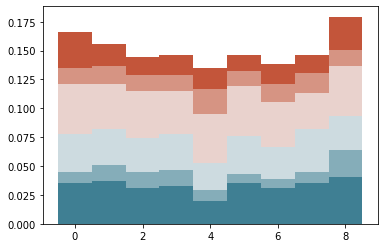

In [43]:
fig, ax = plt.subplots()
bottom=np.zeros(np.unique(clusterResAll).size+1)
for c in range(1,plotRes.shape[1]):
    ax.bar(np.arange(np.unique(clusterResAll).size+1),plotRes[:,c],bottom=bottom,color=np.array(sns.diverging_palette(220, 20, n=6))[c-1],width=1)
    bottom+=plotRes[:,c]
plt.savefig(os.path.join(plotsavepath,'errorsAll.pdf'))